# UNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/UNet.ipynb)

## Environment Set Up

## Requirements

In [1]:
!pip install monai

### Colab Integration

In [2]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ln -s /content/drive/MyDrive/TFM/data /content/data
!ln -s /content/drive/MyDrive/TFM/utils /content/utils
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

Mounted at /content/drive
ln: failed to create symbolic link '/content/data/data': File exists
ln: failed to create symbolic link '/content/utils/utils': File exists
ln: failed to create symbolic link '/content/outputs/outputs': File exists


### Imports

In [3]:
# System
import os
import time
from math import nan

# Data Load & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monai
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.utils import set_determinism
from monai.networks.nets import UNet
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference

# PyTorch
import torch
from torch.utils.data import SequentialSampler

# Utils
from utils.Transforms import Transforms
from utils.plots import plot_gt_vs_pred
from utils.UCSF_Dataset import UCSF_Dataset

### Config

In [4]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [5]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

# Others
%matplotlib inline
pd.set_option("display.max_columns", None)
model_name = "UNet"

## Load Data

In [6]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

# REMOVE
train_df = train_df.iloc[245:]
val_df = val_df.iloc[28:]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100132A,Male,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x106,No,55.0,1.5,1.5,7.0,1165.973886,7.0,1165.973867,259.563087,72.100857,166.567695,65.860322,1.950870e-05,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132A/10...
1,100172A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x106,No,76.0,1.5,1.5,17.0,10390.763751,17.0,10390.763577,7286.306656,22.660269,611.221387,1693.855253,1.738549e-04,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100172A/10...
2,100325A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,78.0,1.5,1.5,2.0,14.402082,2.0,14.402082,9.970672,4.431410,7.201041,2.769631,1.937704e-07,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100325A/10...


In [7]:
b_size = 1
t_size = 3
v_size = 3
spatial_size = (240, 240, 160)

In [8]:
transforms = Transforms(seed)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, transforms.val(), v_size)

# Samplers
train_sampler = SequentialSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=val_sampler)

## Training

### Parameters

In [9]:
# Training
max_epochs = 100
VAL_AMP = True
lr = 1e-4
weight_decay = 1e-5

# Report Frequency
plt_imgs = []
val_interval = 1
plot_interval = 1
best_metric_update = False
max_step = len(train_dataset) // train_loader.batch_size - 1
max_val_step = len(val_dataset) // val_loader.batch_size - 3

# Metrics Storages
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
  f.write(f"epoch,metric,metric_tc,metric_wt,metric_et,train_loss,val_loss\n")

### Create Model, Loss, Optimizer

In [10]:
# Model
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    dropout=0.2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Loss Function
loss_function = DiceLoss(smooth_nr=1e-5, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Execute a typical PyTorch training process

In [11]:
total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # TRAINING
    model.train()
    epoch_loss = 0
    step = 0
    print('TRAIN')
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        print(f"   Batch {step}/{len(train_dataset) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}")

        # Store the image to plot
        if step == max_step:
          plt_imgs = [labels[0], transforms.post()(outputs[0])]

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Plot the Img
    if (epoch + 1) % plot_interval == 0:
      plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], True)

    # VALIDATION
    print('VAL')
    val_loss = 0
    val_step = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            best_val_dice = -1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_step += 1
                val_outputs = inference(val_inputs)
                loss_value = loss_function(val_outputs[0], val_labels[0])
                val_loss += loss_value.item()

                val_outputs = [transforms.post()(x) for x in val_outputs]

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                print(f"   Batch {val_step}/{len(val_dataset) // val_loader.batch_size}"
                      f", val_loss: {loss_value.item():.4f}")

                # Store plot image
                if val_step == max_val_step:
                  plt_imgs = [val_labels[0], val_outputs[0]]

            val_loss /= val_step
            val_loss_values.append(val_loss)

            # Plot the img
            if (epoch + 1) % plot_interval == 0:
              plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], False)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/{model_name}_{epoch+1}.pth"),
                )
                best_metric_update = True

            # Save all metrics in csv
            with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
                f.write(f"{epoch + 1},{metric},{metric_tc},{metric_wt},{metric_et},{epoch_loss},{val_loss}\n")

    # REPORT
    print(f"epoch {epoch + 1}\n"
          f"   average train loss: {epoch_loss:.4f}\n"
          f"   average validation loss: {val_loss:.4f}\n"
          f"   saved as best model: {best_metric_update}\n"
          f"   current mean dice: {metric_values[-1]:.4f}\n"
          f"   current TC dice: {metric_values_tc[-1]:.4f}\n"
          f"   current WT dice: {metric_values_wt[-1]:.4f}\n"
          f"   current ET dice: {metric_values_et[-1]:.4f}")
    print(f"Best Mean Metric: {best_metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    best_metric_update = False

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

Output hidden; open in https://colab.research.google.com to view.

In [12]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.0005 at epoch: 76, total time: 6441.067886590958.


### Plot the loss and metric

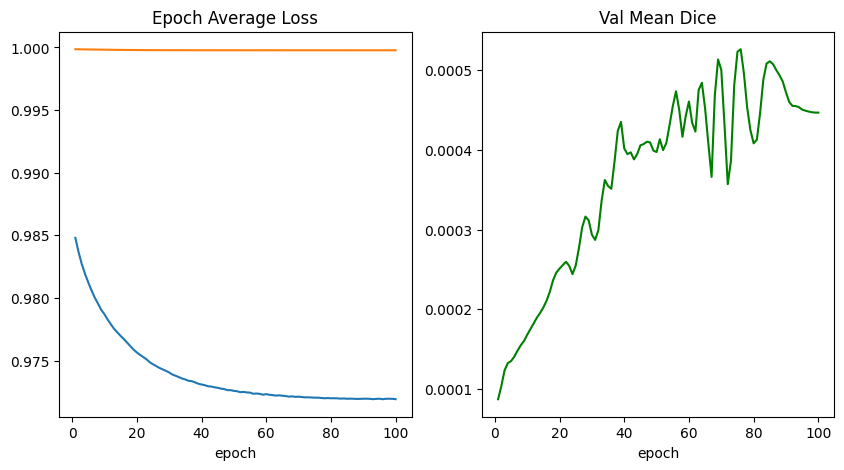

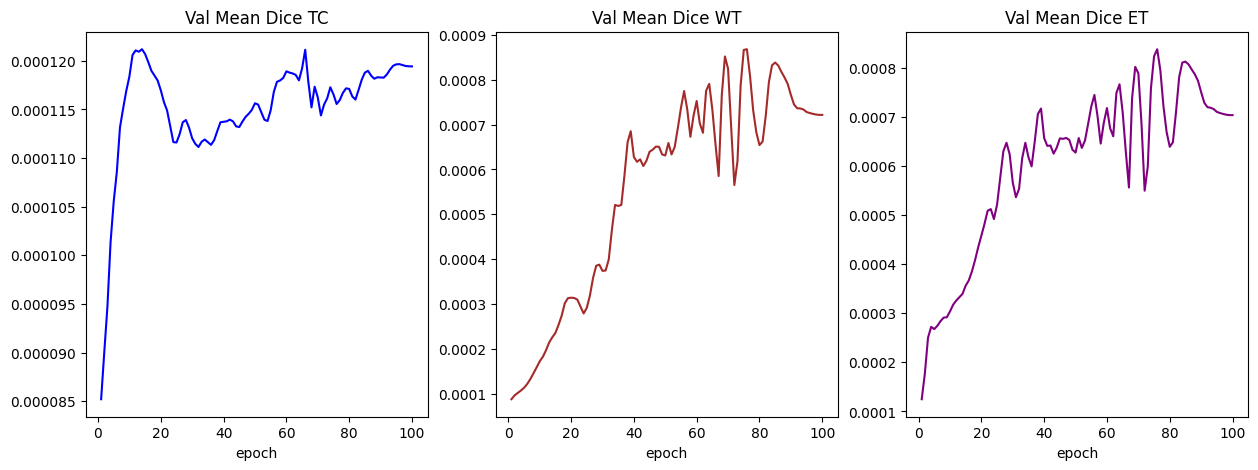

In [13]:
plt.figure("train", (10, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
plt.xlabel("epoch")
plt.plot(x, epoch_loss_values)
plt.plot(x, val_loss_values)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (15, 5))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()